In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import tensorflow as tf
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import rasterio
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
import math
# import gdal
# from google.colab import drive
# drive.mount('/content/drive')
# base ='/content/drive/My Drive/'

2023-05-18 12:07:34.040103: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-18 12:07:34.042962: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-18 12:07:34.094986: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-18 12:07:34.096322: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 12:07:35.135001: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
os.getcwd()
os.chdir('/home/shoyo/Desktop')

In [3]:
# Set seed
def set_seed(seed: int = 42) -> None:
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  tf.experimental.numpy.random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
set_seed()

In [6]:
csv_path = os.getcwd() + '/SOClandsat6mTrue.csv'
df1 = pd.read_csv(csv_path)
df2 = df1[ (df1.EVI<-1) | (df1.EVI>1) ]

df = pd.DataFrame(columns=df1.columns)
for i in range(len(df1)):
    lat = df1.loc[i, 'latitude']
    lon = df1.loc[i, 'longitude']
    if not ((df2['latitude'] == lat) & (df2['longitude'] == lon)).any():
        # df = pd.concat([df, df1.loc[i]]) 
        df.loc[len(df)] = df1.iloc[i]
        # df = df.append(df1.loc[i]) 

df = df.drop(columns=['latitude', 'longitude', 'year'])
df

,SOC,bushland,cropland,forest,grassland,mangrove,shrubland,thicket,wooded_grassland,woodland,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,EVI,ST_B10
0,6.84225,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.300885,0.348584,0.362017,0.474864,0.425474,0.354758,0.202733,288.696186
1,6.84225,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.095735,0.153705,0.163770,0.371642,0.354125,0.233125,0.317605,303.197136
2,6.84225,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166671,0.191600,0.207811,0.356407,0.213353,0.192645,0.228537,236.222743
3,6.84225,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.391195,0.382739,0.383000,0.508249,0.305120,0.206890,0.068306,283.094052
4,6.84225,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.246600,0.280232,0.284247,0.357961,0.203893,0.175059,0.167163,233.638720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13477,13.22570,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040075,0.102803,0.092655,0.342272,0.235930,0.179720,0.358089,270.165391
13478,13.22570,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.169545,0.206367,0.209172,0.452987,0.324095,0.270855,0.424340,268.008620
13479,13.22570,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.351293,0.348598,0.342520,0.485382,0.212115,0.193140,0.374669,267.598458
13480,13.22570,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046812,0.111658,0.069060,0.385943,0.210080,0.142512,0.546647,260.598353


In [14]:
scaler = MinMaxScaler()
# train_df = df[0:int(n*0.8)]
# val_df = df[int(n*0.8):int(n*0.9)]
# test_df = df[int(n*0.9):]
train_df = scaler.fit_transform(df[:11760])
val_df = scaler.transform(df[11760:(11760+1464)])
test_df = scaler.transform(df[(11760+1464):])



In [16]:
Xtrain = train_df[:,1:]
Xtrain = Xtrain.reshape((  int(len(Xtrain)/6), 6, 17))
Ytrain = train_df[:,0][::6]
Ytrain = Ytrain.reshape((len(Ytrain),1))

Xval = val_df[:,1:]
Xval = Xval.reshape((  int(len(Xval)/6), 6, 17))
Yval = val_df[:,0][::6]
Yval = Yval.reshape((len(Yval),1))

Xtest = test_df[:,1:]
Xtest = Xtest.reshape((  int(len(Xtest)/6), 6, 17))
Ytest = test_df[:,0][::6]
Ytest = Ytest.reshape((len(Ytest),1))

# train_mean = train_df.mean()
# train_std = train_df.std()
# train_df = (train_df - train_mean) / train_std
# val_df = (val_df - train_mean) / train_std
# test_df = (test_df - train_mean) / train_std

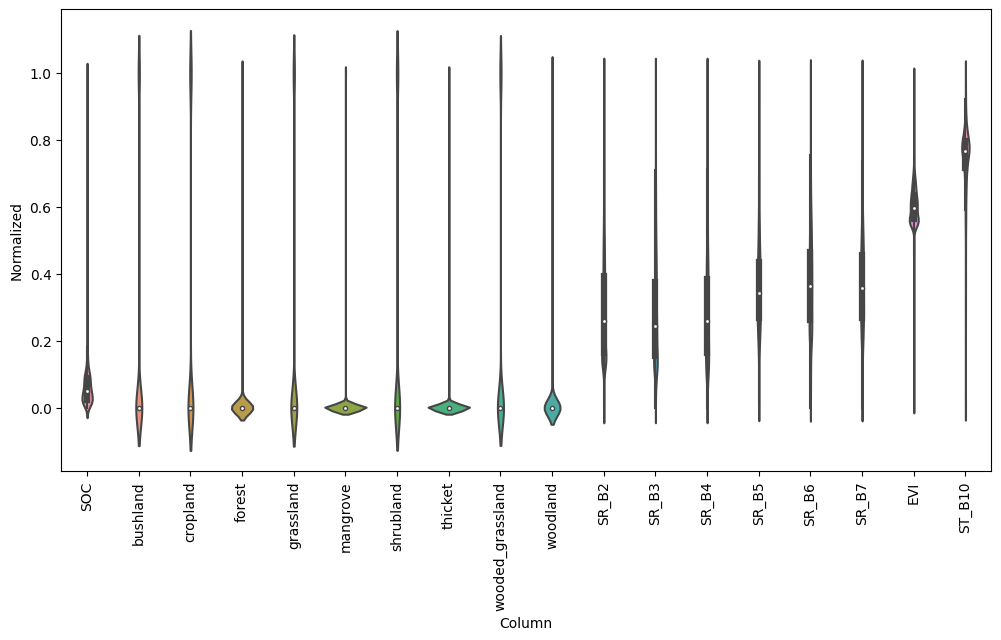

In [17]:
df_std = pd.DataFrame(train_df).melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [20]:
batch_size = 128
units_dense = 1  # labels are of one dimension
lr = 0.001
epochs = 1000

# model = tf.keras.models.Sequential([
#     tf.keras.layers.LSTM(64, input_shape=(6, 17)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(units_dense, activation='linear')])

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(6, 17), return_sequences=True),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(16, return_sequences=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='linear')
])


2023-05-18 12:10:40.430796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-18 12:10:40.432943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-18 12:10:40.434307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [21]:
# def r2_metric(y_true, y_pred):
#     return r2_score(y_true.numpy(), y_pred.numpy())

model.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            metrics=[tf.keras.metrics.MeanAbsoluteError(), 
                     tf.keras.metrics.RootMeanSquaredError(), 
                    #  r2_metric
                    ])

# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='LSTM', update_freq='epoch', profile_batch=0)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss')

history = model.fit(Xtrain, Ytrain, epochs=epochs, batch_size=batch_size,validation_data=(Xval, Yval), callbacks=[early_stopping])

Epoch 1/1000


2023-05-18 12:10:44.167541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-18 12:10:44.169604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-18 12:10:44.170936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/16 [===========================>..] - ETA: 0s - loss: 1.2660 - mean_absolute_error: 0.8783 - root_mean_squared_error: 1.1252

2023-05-18 12:10:53.113674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-18 12:10:53.115665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-18 12:10:53.117433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 11s 178ms/step - loss: 1.2519 - mean_absolute_error: 0.8733 - root_mean_squared_error: 1.1189 - val_loss: 0.0020 - val_mean_absolute_error: 0.0323 - val_root_mean_squared_error: 0.0445
Epoch 2/1000
16/16 [==============================] - 1s 58ms/step - loss: 0.7760 - mean_absolute_error: 0.6958 - root_mean_squared_error: 0.8809 - val_loss: 0.0023 - val_mean_absolute_error: 0.0346 - val_root_mean_squared_error: 0.0478
Epoch 3/1000
16/16 [==============================] - 1s 55ms/step - loss: 0.6498 - mean_absolute_error: 0.6327 - root_mean_squared_error: 0.8061 - val_loss: 0.0028 - val_mean_absolute_error: 0.0394 - val_root_mean_squared_error: 0.0530
Epoch 4/1000
16/16 [==============================] - 1s 54ms/step - loss: 0.5451 - mean_absolute_error: 0.5777 - root_mean_squared_error: 0.7383 - val_loss: 0.0067 - val_mean_absolute_error: 0.0703 - val_root_mean_squared_error: 0.0819
Epoch 5/1000
16/16 [==============================] - 1s 54ms/s

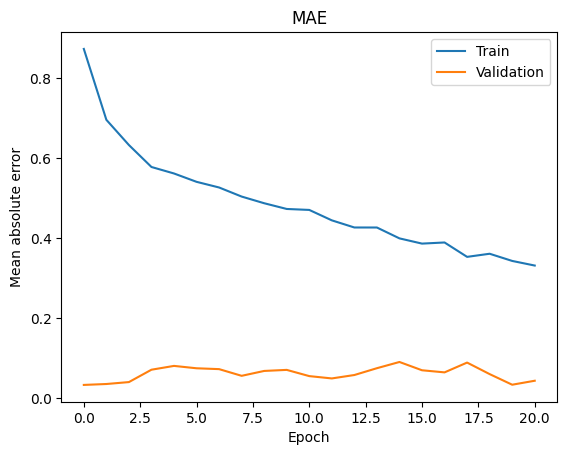

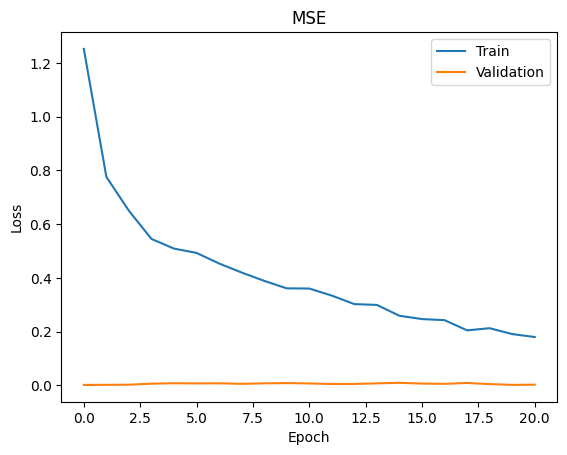

In [22]:
# Plot the training and validation accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('MAE')
plt.ylabel('Mean absolute error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MSE')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [23]:
Ypred = model.predict(Xtest)
print('shape', Ypred.shape)
print(Ypred[:10], np.max(Ypred), np.min(Ypred))

2023-05-18 12:11:13.074451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-18 12:11:13.076460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-18 12:11:13.077871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 2s 12ms/step
shape (43, 1)
[[0.03853888]
 [0.04085539]
 [0.03931747]
 [0.01287678]
 [0.02343558]
 [0.03812944]
 [0.02858883]
 [0.03820359]
 [0.01137874]
 [0.03913159]] 0.040855393 0.011378737


In [24]:
mse = mean_squared_error(Ytest, Ypred)
print("RMSE", math.sqrt(mse))
mae = mean_absolute_error(Ytest, Ypred)
print("MAE", mae)
R_square = r2_score(Ytest, Ypred) 
print('Coefficient of Determination', R_square) 

RMSE 0.05121943884506985
MAE 0.04421462439378965
Coefficient of Determination -3.8312592079854833


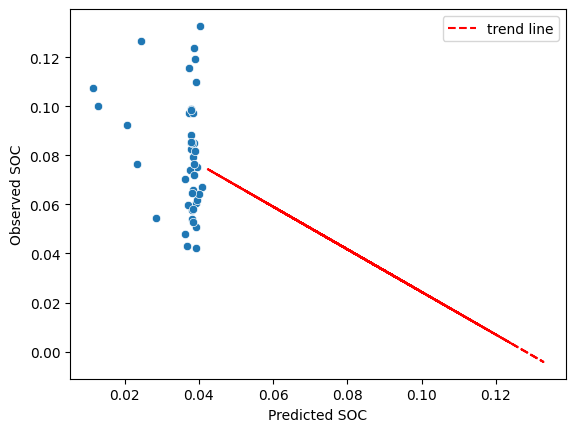

In [25]:
scatterplot=sns.scatterplot(x=np.squeeze(Ypred), y=np.squeeze(Ytest))
z = np.polyfit(np.squeeze(Ypred), np.squeeze(Ytest), 1)  #Least squares polynomial fit.
p = np.poly1d(z)                           #A one-dimensional polynomial class.
scatterplot.plot(np.squeeze(Ytest), p(np.squeeze(Ytest)), "r--", label='trend line')
plt.legend()
plt.xlabel("Predicted SOC")
plt.ylabel("Observed SOC")
plt.show()